# WASSA 2017 Shared Task On Emotion Intensity

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib  inline
from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from emoint.ensembles.blending import blend
from sklearn.linear_model import Ridge

In [2]:
def get_xy(path, tokenizer, featurizer):
    df = pd.read_csv(path, header=None, sep='\t')
    tweets = df[1]
    intensities = df[3]
    X = []
    for t in tweets:
        tokens = tokenizer.tokenize(t)
        features = featurizer.featurize(tokens)
        X.append(features)
    X, y = np.array(X), np.array(intensities)
    print("Shapes X: {}, y: {}".format(X.shape, y.shape))
    return X, y

def metrics(y_pred, y, print_metrics=False):
    p1 = pearsonr(y_pred, y)[0]
    s1 = spearmanr(y_pred, y)[0]
    ind = np.where(y >= 0.5)
    ydt = np.take(y_pred, ind).reshape(-1)
    ydpt = np.take(y, ind).reshape(-1)
    p2 = pearsonr(ydt, ydpt)[0]
    s2 = spearmanr(ydt, ydpt)[0]
    if print_metrics:
        print("Validation Pearsonr: {}".format(p1))
        print("Validation Spearmanr: {}".format(s1))
        print("Validation Pearsonr >= 0.5: {}".format(p2))
        print("Validation Spearmanr >= 0.5: {}".format(s2))
    return np.array((p1, s1, p2, s2))

def train(train_path, dev_path, featurizer, tokenizer):
    X_train, y_train = get_xy(train_path, tokenizer, featurizer)
    X_dev, y_dev = get_xy(dev_path, tokenizer, featurizer)
    regr = GradientBoostingRegressor()
    regr.fit(X_train, y_train)
    y_dev_pred = regr.predict(X_dev)
    metrics(y_dev_pred, y_dev, True)
    return regr, featurizer.features

## Training Models

In [3]:
featurizer = EmoIntFeaturizer()
tokenizer = TweetTokenizer()

print("---------------- ANGER --------------------")
anger_regr, anger_features = train('../resources/emoint/anger-ratings-0to1.train.txt',
    '../resources/emoint/anger-ratings-0to1.dev.gold.txt', featurizer, tokenizer)

print("---------------- FEAR --------------------")
fear_regr, fear_features = train('../resources/emoint/fear-ratings-0to1.train.txt',
    '../resources/emoint/fear-ratings-0to1.dev.gold.txt', featurizer, tokenizer)

print("---------------- JOY --------------------")
joy_regr, joy_features = train('../resources/emoint/joy-ratings-0to1.train.txt',
    '../resources/emoint/joy-ratings-0to1.dev.gold.txt', featurizer, tokenizer)

print("---------------- SADNESS --------------------")
sadness_regr, sadness_features = train('../resources/emoint/sadness-ratings-0to1.train.txt',
    '../resources/emoint/sadness-ratings-0to1.dev.gold.txt', featurizer, tokenizer)

---------------- ANGER --------------------
Shapes X: (857, 455), y: (857,)
Shapes X: (84, 455), y: (84,)
Validation Pearsonr: 0.643157466443
Validation Spearmanr: 0.620405233321
Validation Pearsonr >= 0.5: 0.349008505686
Validation Spearmanr >= 0.5: 0.289837977558
---------------- FEAR --------------------
Shapes X: (1147, 455), y: (1147,)
Shapes X: (110, 455), y: (110,)
Validation Pearsonr: 0.565311542364
Validation Spearmanr: 0.533524085718
Validation Pearsonr >= 0.5: 0.454226444107
Validation Spearmanr >= 0.5: 0.410971301472
---------------- JOY --------------------
Shapes X: (823, 455), y: (823,)
Shapes X: (79, 455), y: (79,)
Validation Pearsonr: 0.723935450526
Validation Spearmanr: 0.719557861455
Validation Pearsonr >= 0.5: 0.337190683984
Validation Spearmanr >= 0.5: 0.301028591252
---------------- SADNESS --------------------
Shapes X: (786, 455), y: (786,)
Shapes X: (74, 455), y: (74,)
Validation Pearsonr: 0.552641415133
Validation Spearmanr: 0.560515971029
Validation Pearsonr 

## Feature Importance

In [4]:
def plot_fig(f, regr, labels, title, num, subnum, cnt):
    ax = f.add_subplot(subnum)
    f.subplots_adjust(hspace=.4)
    if subnum % 2 == 0:
        ax.yaxis.tick_right()
    indices = np.argsort(regr.feature_importances_)[-10:]
    plt.barh(np.arange(len(indices)), regr.feature_importances_[indices], color=colors[cnt])
    plt.yticks(np.arange(len(indices)) + 0.75/2 , np.array(labels)[indices])
    plt.xlabel('Relative importance')
    plt.title(title)

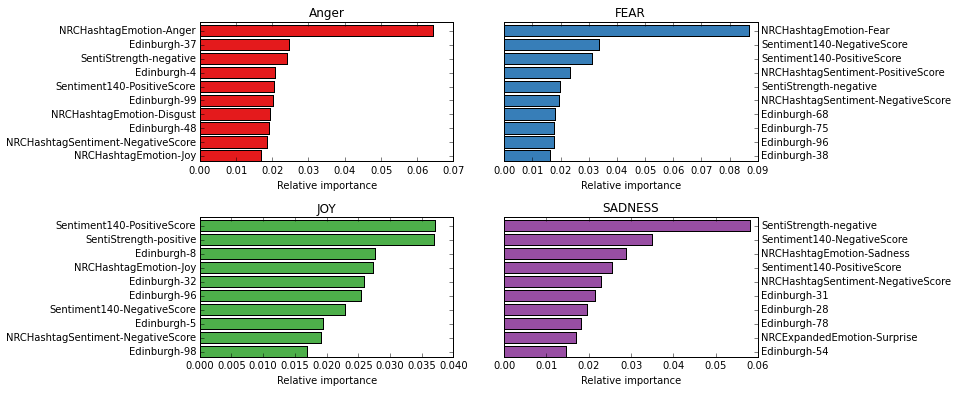

In [5]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
f = plt.figure(figsize=(10, 6))
plot_fig(f, anger_regr, anger_features, 'Anger', 1, 221, 0)
plot_fig(f, fear_regr, fear_features, 'FEAR', 1, 222, 1)
plot_fig(f, joy_regr, joy_features, 'JOY', 2, 223, 2)
plot_fig(f, sadness_regr, sadness_features, 'SADNESS', 2, 224, 3)

# Blending

In [6]:
def blend_train(train_path, dev_path, featurizer, tokenizer, clfs):
    featurizer = EmoIntFeaturizer()
    tokenizer = TweetTokenizer()
    X_train, y_train = get_xy(train_path, tokenizer, featurizer)
    X_dev, y_dev = get_xy(dev_path, tokenizer, featurizer)
    y_dev_pred = blend(X_train, y_train, X_dev, clfs, regr=True, blend_clf=Ridge())
    metrics(y_dev_pred, y_dev, True)

In [7]:
clfs = [RandomForestRegressor(), ExtraTreesRegressor(), BaggingRegressor(), GradientBoostingRegressor()]

print("---------------- ANGER --------------------")
blend_train('../resources/emoint/anger-ratings-0to1.train.txt',
    '../resources/emoint/anger-ratings-0to1.dev.gold.txt', featurizer, tokenizer, clfs)

print("---------------- FEAR --------------------")
blend_train('../resources/emoint/fear-ratings-0to1.train.txt',
    '../resources/emoint/fear-ratings-0to1.dev.gold.txt', featurizer, tokenizer, clfs)

print("---------------- JOY --------------------")
blend_train('../resources/emoint/joy-ratings-0to1.train.txt',
    '../resources/emoint/joy-ratings-0to1.dev.gold.txt', featurizer, tokenizer, clfs)

print("---------------- SADNESS --------------------")
blend_train('../resources/emoint/sadness-ratings-0to1.train.txt',
    '../resources/emoint/sadness-ratings-0to1.dev.gold.txt', featurizer, tokenizer, clfs)

---------------- ANGER --------------------
Shapes X: (857, 455), y: (857,)
Shapes X: (84, 455), y: (84,)
Validation Pearsonr: 0.650128969601
Validation Spearmanr: 0.63589136421
Validation Pearsonr >= 0.5: 0.339763224854
Validation Spearmanr >= 0.5: 0.253864371545
---------------- FEAR --------------------
Shapes X: (1147, 455), y: (1147,)
Shapes X: (110, 455), y: (110,)
Validation Pearsonr: 0.587603648477
Validation Spearmanr: 0.542643934791
Validation Pearsonr >= 0.5: 0.480971152336
Validation Spearmanr >= 0.5: 0.487507216477
---------------- JOY --------------------
Shapes X: (823, 455), y: (823,)
Shapes X: (79, 455), y: (79,)
Validation Pearsonr: 0.740497830362
Validation Spearmanr: 0.735895125232
Validation Pearsonr >= 0.5: 0.354656185972
Validation Spearmanr >= 0.5: 0.308830409336
---------------- SADNESS --------------------
Shapes X: (786, 455), y: (786,)
Shapes X: (74, 455), y: (74,)
Validation Pearsonr: 0.551505101643
Validation Spearmanr: 0.5716320263
Validation Pearsonr >= 